In [76]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import gensim
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
import pickle

nltk.download('punkt')

SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 100
BATCH_SIZE = 64
PAD_WORD = "__PAD__"
WORD_EMBEDDING_FILE = 'word_embedding.csv'
TOKENIZER_FILE = 'tokenizer.pickle'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isjha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1>Preprocess Raw Data</h1>

In [9]:
data = pd.read_csv("dota2_chat_messages.csv", encoding="utf_8", usecols=["match", "slot", "text"])
data = data.astype({"match": int, "slot": int, "text": str})
data.head(10)

,match,slot,text
0,0,9,ладно гг
1,0,9,изи
2,0,9,од
3,0,9,ебаный
4,0,9,мусор на войде
5,0,9,мусор
6,0,9,на войде
7,0,9,репорт
8,0,9,100%
9,1,0,twitch.tv/rage_channel


In [14]:
data = data.groupby(['match', 'slot'])['text'].apply('. '.join)
data.reset_index()
data.head(10)

match  slot
0      9       ладно гг . изи. од. ебаный. мусор на войде. му...
1      0       twitch.tv/rage_channel. https://www.twitch.tv/...
       4       где даша?. даша домой. долбоеб сука на дизрапторе
       6       даун с 1 тычки забашил . шок . стример харду с...
       7                                   2 даша подряд . баша 
       8                                                     )))
2      0       yes dog. yeah . fast and furious. too fas. hah...
       2                               no idiot. we too pro. lol
       4                                HAHAH. COMMEND ME TY. EZ
       6                                              carry. lul
Name: text, dtype: object

In [15]:
data = data.reset_index()
data.head(10)

,match,slot,text
0,0,9,ладно гг . изи. од. ебаный. мусор на войде. му...
1,1,0,twitch.tv/rage_channel. https://www.twitch.tv/...
2,1,4,где даша?. даша домой. долбоеб сука на дизрапторе
3,1,6,даун с 1 тычки забашил . шок . стример харду с...
4,1,7,2 даша подряд . баша
5,1,8,)))
6,2,0,yes dog. yeah . fast and furious. too fas. hah...
7,2,2,no idiot. we too pro. lol
8,2,4,HAHAH. COMMEND ME TY. EZ
9,2,6,carry. lul


In [17]:
data.to_csv("dota2_chat_joined.csv")

In [18]:
data.describe()

,match,slot
count,4.747547e+06,4.747547e+06
mean,4.999057e+05,4.493503e+00
std,2.887862e+05,2.873926e+00
min,0.000000e+00,0.000000e+00
25%,2.497860e+05,2.000000e+00
50%,4.999710e+05,5.000000e+00
75%,7.500870e+05,7.000000e+00
max,9.999990e+05,9.000000e+00


<h1>Word Embedding<h1>

In [5]:
data_word_embedding = pd.read_csv("data2_chat_joined_10000.csv", encoding="utf_8", usecols=["match", "slot", "text"])
data_word_embedding.head(10)

,match,slot,text
0,0,9,ладно гг . изи. од. ебаный. мусор на войде. му...
1,1,0,twitch.tv/rage_channel. https://www.twitch.tv/...
2,1,4,где даша?. даша домой. долбоеб сука на дизрапторе
3,1,6,даун с 1 тычки забашил . шок . стример харду с...
4,1,7,2 даша подряд . баша
5,1,8,)))
6,2,0,yes dog. yeah . fast and furious. too fas. hah...
7,2,2,no idiot. we too pro. lol
8,2,4,HAHAH. COMMEND ME TY. EZ
9,2,6,carry. lul


In [6]:
data_word_embedding_numpy = data_word_embedding.drop(columns=['match', 'slot']).to_numpy().flatten()

In [111]:
# melakukan tokenisasi (membuat tanda baca, dll)
# lalu encoded setiap kalimat ke angka, dictionary index
word_embedding_tokenizer = Tokenizer(oov_token='OOV')
word_embedding_tokenizer.fit_on_texts(data_word_embedding_numpy)
word_embedding_sequences = word_embedding_tokenizer.texts_to_sequences(data_word_embedding_numpy)
# mengembalikan sequence index kembali katanya
# karena input gensim adalah kata
data_word_embedding_numpy_temp = [[word_embedding_tokenizer.index_word[word_index] for word_index in sentence] for sentence in word_embedding_sequences]
word_embedding_model = gensim.models.Word2Vec(data_word_embedding_numpy_temp, min_count = 1, size = EMBEDDING_SIZE, window = 5, sg = 1) 
word_index = word_embedding_tokenizer.word_index
# membuat array yang berisi value word_embedding berdasar index katanya pada dictionary
word_embedding_temp = np.zeros((len(word_index)+1, EMBEDDING_SIZE))
for word, word_object in word_embedding_model.wv.vocab.items():
    index = word_index[word]
    word_embedding_temp[index] = word_embedding_model.wv[word]    
    
# store tokenizer dictionary 
with open(TOKENIZER_FILE, 'wb') as handle:
    pickle.dump(word_embedding_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# word embedding to fil
np.savetxt(WORD_EMBEDDING_FILE, word_embedding_temp, delimiter=',')

<h1>Classification</h1>

In [112]:
#load word embedding
word_embedding = np.loadtxt(WORD_EMBEDDING_FILE, delimiter=',')
#load tokenizer 
with open(TOKENIZER_FILE, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [113]:
data = pd.read_csv("dota2_chat_final.csv", encoding="utf_8", usecols=["category", "match", "slot", "text"])
data["category"].value_counts()

0    318
1     81
Name: category, dtype: int64

In [114]:
data.head()

,category,match,slot,text
0,0,2,0,yes dog. yeah . fast and furious. too fas. hah...
1,0,2,2,no idiot. we too pro. lol
2,1,2,4,HAHAH. COMMEND ME TY. EZ
3,1,6,0,so ya mama likes dick ehh?. figures. ur not ev...
4,1,6,1,reprot. SAD. fucking reported axe. WORST HOOK ...


In [115]:
X_raw = data.drop(columns=['category', 'match', 'slot']).to_numpy().flatten()
y_raw = data.drop(columns=['text', 'match', 'slot']).to_numpy().flatten()

In [117]:
word_embedding_tokenizer.word_index

{'OOV': 1,
 'gg': 2,
 'ez': 3,
 'не': 4,
 'lol': 5,
 'i': 6,
 'u': 7,
 'ты': 8,
 'в': 9,
 'я': 10,
 'xd': 11,
 'на': 12,
 'report': 13,
 'wp': 14,
 'you': 15,
 'me': 16,
 'и': 17,
 'mid': 18,
 'a': 19,
 'у': 20,
 'end': 21,
 'что': 22,
 'изи': 23,
 'no': 24,
 'is': 25,
 'and': 26,
 'а': 27,
 'game': 28,
 'd': 29,
 'to': 30,
 'да': 31,
 'this': 32,
 'go': 33,
 'haha': 34,
 'ty': 35,
 'с': 36,
 'он': 37,
 'the': 38,
 'my': 39,
 '3': 40,
 'как': 41,
 'so': 42,
 'гг': 43,
 '2': 44,
 '1': 45,
 'team': 46,
 'вы': 47,
 'for': 48,
 'за': 49,
 'ggwp': 50,
 'сука': 51,
 'nice': 52,
 'pls': 53,
 'нахуй': 54,
 'he': 55,
 'это': 56,
 'just': 57,
 'ну': 58,
 '0': 59,
 'меня': 60,
 'we': 61,
 'репорт': 62,
 '4': 63,
 'fuck': 64,
 'wtf': 65,
 'it': 66,
 'not': 67,
 'that': 68,
 'fucking': 69,
 'what': 70,
 'why': 71,
 'in': 72,
 'sf': 73,
 'ok': 74,
 'are': 75,
 'просто': 76,
 'dont': 77,
 '5': 78,
 'noob': 79,
 'commend': 80,
 'all': 81,
 'так': 82,
 'че': 83,
 'sad': 84,
 'have': 85,
 'am': 86,
 'im

In [116]:
word_embedding_tokenizer.sequences_to_texts([[0], [1], [2]])
# word_embedding_tokenizer.texts_to_sequences([['Makassar']])

['OOV', 'OOV', 'gg']

In [125]:
word_embedding[7]

array([-0.52489412,  0.32899657, -0.20936982, -0.30004543, -0.09107108,
        0.05559709, -0.62406999,  0.11284356, -0.51436317, -0.52935606,
        0.64609575,  0.06674162, -0.27763477,  0.33480886,  0.81060755,
        0.25981653, -0.26628065,  0.38385254, -0.76333565, -0.59562355,
        0.61687064,  1.17413223,  0.31584117,  0.35176465, -0.24574602,
       -0.10374842,  0.19592713,  0.42683867, -0.56297904, -0.12066084,
       -0.15878049, -0.3247202 ,  0.17367646, -0.02040786,  0.21203905,
       -0.03045437,  0.14981909, -0.35696527,  0.05961173, -0.02317832,
       -0.15593125, -0.28276762, -0.31367341,  0.06426731, -0.70247459,
        0.56376731, -0.26410839,  0.46594074, -0.14467807,  0.07097369,
       -0.84288394,  0.00481923, -0.142666  ,  0.60093844, -0.78511178,
        0.38656074,  0.06688862, -0.43059015, -0.77468544,  0.19352694,
        0.79653019, -0.29064026, -0.6548506 ,  0.38489357, -0.33490562,
        0.32697499,  0.06072708, -0.06184655,  0.13602871,  0.01

In [15]:
def tokenize(X):
    return tokenizer.texts_to_sequences(X)

def keras_tokenize(X):
    X_numpy = X.to_numpy()
    X_numpy = X_numpy.flatten()
    keras_tokenizer.fit_on_texts(X_numpy);
    return result

def create_word_embedding(X):
    X_temp = tokenizer.texts_to_sequences(X);
    X_temp = [[tokenizer.index_word[word_index] for word_index in sentence] for sentence in X_temp]
    model = gensim.models.Word2Vec(X_temp, min_count = 1, size = EMBEDDING_SIZE, window = 5, sg = 1) 
    word_index = tokenizer.word_index
    word_embedding = np.zeros((len(word_index)+1, EMBEDDING_SIZE))
    for word, word_object in model.wv.vocab.items():
        index = tokenizer.word_index[word]
        word_embedding[index] = model.wv[word]    
    return word_embedding
    
def is_match(X1, X2):
    for i in range(len(X1)):
        arr1 = X1[i]
        arr2 = X2[i]
        if(len(arr1) != len(arr2)):
            print(i)
            return False
    return True

In [85]:
X = tokenizer.texts_to_sequences(X_raw)
y = to_categorical(y_raw)

In [86]:
X

[[272, 242, 257, 282, 26, 6412, 150, 4136, 34, 84],
 [24, 236, 61, 150, 192, 5],
 [305, 80, 16, 35, 3],
 [42,
  126,
  1459,
  4148,
  376,
  3143,
  6441,
  104,
  67,
  267,
  19,
  107,
  4149,
  449,
  1853,
  691,
  952,
  2],
 [1042,
  84,
  69,
  344,
  222,
  851,
  503,
  72,
  6442,
  15,
  1854,
  87,
  38,
  45,
  4150,
  138,
  6443,
  6444,
  338,
  52,
  639,
  404,
  1043,
  6445,
  167,
  6446,
  3,
  28,
  35,
  35,
  4151,
  6447,
  80,
  16,
  2539,
  16],
 [2],
 [222, 25, 222],
 [263, 4152, 6, 571, 7, 1044, 2],
 [357, 67, 2136, 6450, 223, 1209, 80, 35, 1209, 80, 35],
 [70,
  4155,
  4156,
  521,
  898,
  664,
  67,
  544,
  1461,
  172,
  193,
  21,
  231,
  953,
  1210,
  2137,
  74,
  7,
  358,
  3146,
  954,
  66,
  2540,
  6451,
  72,
  147,
  3147,
  30,
  450,
  19,
  6452,
  955,
  135,
  249,
  451,
  6453,
  6454,
  572,
  6455,
  250,
  6456,
  30,
  1647,
  1462,
  3148,
  1326,
  2541,
  104,
  232,
  135,
  69,
  284,
  640,
  55,
  339,
  405,
  1856,

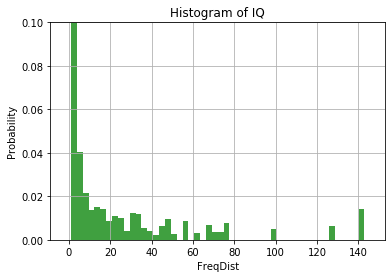

In [87]:
words = []
[words.extend(sentence) for sentence in X]
freqdist = nltk.FreqDist(words)
x_plot = [freqdist[word] for word in words]

# the histogram of the data
n, bins, patches = plt.hist(x_plot, 50, density=1, facecolor='g', alpha=0.75)


plt.xlabel('FreqDist')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.axis([min(x_plot)-10, max(x_plot)+ 10, 0, 0.1])
plt.grid(True)
plt.show()

In [88]:
X_padded = pad_sequences(X, maxlen=SEQUENCE_LENGTH, padding='post', value=0)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.1, random_state=42)

<h1>Validation Test</h1>

In [91]:
word_embedding.shape

(18975, 100)

In [92]:
model_val = Sequential()
model_val.add(Embedding(
    input_dim=len(tokenizer.word_index)+1, 
    output_dim=EMBEDDING_SIZE, 
    input_length=SEQUENCE_LENGTH, 
    weights=[word_embedding],
    trainable=False))
model_val.add(LSTM(128, recurrent_dropout=0.2))
model_val.add(Dropout(0.3))
model_val.add(Dense(2, activation="softmax"))
# compile as rmsprop optimizer
# aswell as with recall metric
model_val.compile(optimizer="rmsprop", loss="categorical_crossentropy", 
      metrics=["accuracy"])
model_val.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1897500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 2,015,006
Trainable params: 117,506
Non-trainable params: 1,897,500
_________________________________________________________________


In [93]:
model_val.fit(X_train, y_train, epochs=100, batch_size=64, shuffle=True, validation_split=0.3)

Train on 251 samples, validate on 108 samples
Epoch 1/100
251/251 [==============================] - 5s 20ms/sample - loss: 0.6263 - accuracy: 0.7888 - val_loss: 0.9674 - val_accuracy: 0.3333
Epoch 2/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.6313 - accuracy: 0.7291 - val_loss: 0.4701 - val_accuracy: 0.8241
Epoch 3/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4747 - accuracy: 0.8287 - val_loss: 0.4453 - val_accuracy: 0.8241
Epoch 4/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4424 - accuracy: 0.8247 - val_loss: 0.4393 - val_accuracy: 0.8241
Epoch 5/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4476 - accuracy: 0.8247 - val_loss: 0.4328 - val_accuracy: 0.8241
Epoch 6/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4330 - accuracy: 0.8287 - val_loss: 0.4324 - val_accuracy: 0.8148
Epoch 7/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4462

Epoch 57/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4169 - accuracy: 0.8167 - val_loss: 0.4081 - val_accuracy: 0.8056
Epoch 58/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4593 - accuracy: 0.7849 - val_loss: 0.4147 - val_accuracy: 0.8241
Epoch 59/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4301 - accuracy: 0.8287 - val_loss: 0.4120 - val_accuracy: 0.8241
Epoch 60/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4111 - accuracy: 0.8327 - val_loss: 0.4095 - val_accuracy: 0.8241
Epoch 61/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.3934 - accuracy: 0.8287 - val_loss: 0.5974 - val_accuracy: 0.8241
Epoch 62/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.5199 - accuracy: 0.8167 - val_loss: 0.4725 - val_accuracy: 0.8333
Epoch 63/100
251/251 [==============================] - 1s 4ms/sample - loss: 0.4717 - accuracy: 0.8247 - val_loss: 0.4540 -